In [1]:
%load_ext autoreload
%autoreload 2
import scipy
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import keras

import time

2024-06-04 10:58:24.058174: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 10:58:24.104537: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 10:58:24.104572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 10:58:24.105678: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-04 10:58:24.113515: I tensorflow/core/platform/cpu_feature_guar

## Observations
At each timestep $t$, we observe $S=4$ artificial locations. The observed value $y_{s,t}$ is realization of random variable $Y_s$, which is normally distributed with unit variance and a location-specific mean: $Y_{s,t} \sim \mathcal{N}(\mu_s, 1)$. The means are $\mu = [5, 15, 25, 35]$.

In [2]:
S=4
scale = 1
means = [5.0, 15.0, 25.0, 35.0]
# simulate data for each location
data_distributions = [scipy.stats.norm(loc=mean, scale=scale) for mean in means]

In total, we observe $T=1000$ examples. We frame this as a machine learning problem and our goal is to train a model given some features $x$ to accurately predict $y$. However, we are unconcerned with learning here, and care only about our ability to calculate gradients. Here, we use $x \in \mathbb{R}^F$ as an $F=20$ dimensional feature vector, but the features are uninformative and sampled from a standard normal. 

In [3]:
T=1000
# create random state for sampling
seed=360
rng = np.random.RandomState(seed)
y_TS = np.array([dist.rvs(size=T, random_state=rng) for dist in data_distributions]).T
assert(y_TS.shape == (T, S))

F=20
# x doesn't matter because we aren't learning
x_TF = rng.standard_normal(size=(T, F))

2024-06-04 10:58:36.420056: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-04 10:58:36.420094: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: s1cmp008.pax.tufts.edu
2024-06-04 10:58:36.420102: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: s1cmp008.pax.tufts.edu
2024-06-04 10:58:36.420221: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.129.3
2024-06-04 10:58:36.420249: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.129.3
2024-06-04 10:58:36.420254: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.129.3


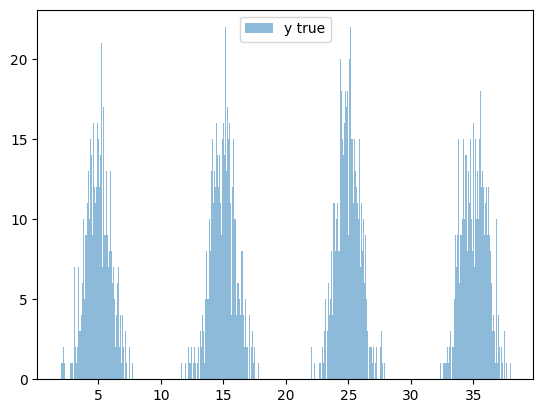

In [4]:
plt.hist(tf.reshape(y_TS, [-1]).numpy(),alpha=0.5, bins=1000, label='y true')
plt.legend()

## Model
We will model this with the true model: predictions $\hat{y}_{s,t}$ will come from S, location-specific normal distributions, where the mean is determined by a function $f_{\phi_s}(x)$ with location-specific parameters $\phi_s$, and the variance is fixed to the true value of 1.

$$p(\hat{y}_{s,t}) = \mathcal{N}(\hat{y}_{s,t}| f_{\phi_s}(x), 1)$$
All locations are independent:
$$p(\hat{y}_{t}) = \prod_{s=1}^S \mathcal{N}(\hat{y}_{s,t}| f_{\phi_s}(x), 1)$$

Our model is a simple linear model with an intercept:
$$f_{\phi_s}(x_s) = \phi_s x_s + \phi_{s,0}$$
Our model can trivially recover the true data generating process by setting the coefficient terms of $\phi_s$ to 0 and the intercept to the true mean $\phi_{s,0} = \mu_s$

## Objective
We will use our model's predictions $\hat{y}$ in order to choose some action $\theta$, which can be calculated by a deterministic but not necessarily differentiable function $a$ of $\hat{y}$:
$$\theta_t = a(\hat{y}_t)$$

Given a decision $\theta$, we can calculate a loss between our action and the observed outcome $\mathcal{L}(\theta_t, y_t)$. Our goal is to calculate gradients of that loss with respect to our model parameters. We can use the chain rule to decompose the gradient into two parts:
$$ \nabla_\phi \mathcal{L}(\theta_t, y_t) = \nabla_\phi \theta \nabla_\theta  \mathcal{L}(\theta_t, y_t)$$

When $\theta$ is non-differentiable, we can obtain gradients using the score-function trick, where we can approximate the gradient using $M$ samples from our probabilistic model $p$
$$\nabla_\phi \theta = \frac{1}{M} \sum_{m=1}^M \nabla_\phi \log p(y^m) a(y)$$

Our loss is mean-squared error and easy to differentiate: 
$$\mathcal{L} (\theta_t, y_t) = \frac{1}{S}\sum_{s=1}^S(y_t-\theta_t)^2$$

## Implementing the model

In [5]:
inputs = keras.Input(shape=F)
linear_layer = keras.layers.Dense(S, activation = None)
distribution_layer = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=1))

In [6]:
predicted_means = linear_layer(inputs)
distributions = distribution_layer(predicted_means)
model = keras.Model(inputs=inputs, outputs=distributions)

In [7]:
model_distributions = model(x_TF)
print(f'Model parameter shapes: {[w.shape for w in model.get_weights()]}')

Model parameter shapes: [(20, 4), (4,)]


### Set weights to true values
We'll set the linear coefficients to 0 and the biases to the true means

In [8]:
linear_weights = model.trainable_variables[0]
linear_weights.assign(tf.zeros_like(linear_weights))

biases = model.trainable_variables[1]
biases.assign(means)

print(f'Max linear weight magnitude {tf.reduce_max(tf.abs(model.trainable_variables[0]))}')
print(f'Biases {model.get_weights()[1]}')

Max linear weight magnitude 0.0
Biases [ 5. 15. 25. 35.]


In [9]:
M=500
model_distributions = model(x_TF)
sample_y_MTS = model_distributions.sample(M)
assert(sample_y_MTS.shape == (M, T, S))

sample_log_probs_MTS = model_distributions.log_prob(sample_y_MTS)
sample_actions_MTS = tf.identity(sample_y_MTS)
expected_actions_TS = tf.reduce_mean(sample_actions_MTS, axis=0)
loss_T = keras.losses.mean_squared_error(y_TS, expected_actions_TS)
loss = tf.reduce_mean(loss_T)

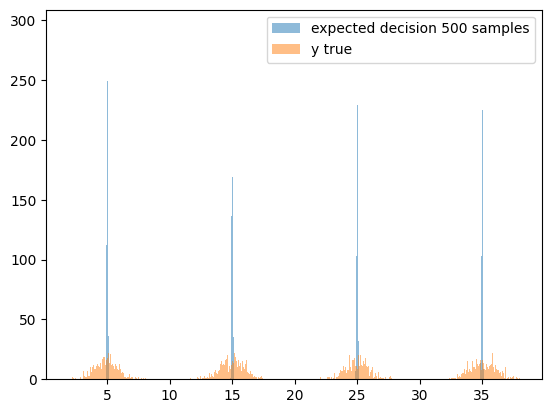

In [10]:
plt.hist(tf.reshape(expected_actions_TS, [-1]).numpy(),alpha=0.5, bins=1000, label=f'expected decision {M} samples')
plt.hist(tf.reshape(y_TS, [-1]).numpy(),alpha=0.5, bins=1000, label='y true')
plt.legend()

### Differentiate the score function trick
We'll take $M=5$ samples, and use the identity function as our action $a(y)=y$

$$ \nabla_\phi \mathcal{L}(\theta_t, y_t) = \nabla_\phi \theta \nabla_\theta  \mathcal{L}(\theta_t, y_t)$$

When $\theta$ is non-differentiable, we can obtain gradients using the score-function trick, where we can approximate the gradient using $M$ samples from our probabilistic model $p$
$$\nabla_\phi \theta = \frac{1}{M} \sum_{m=1}^M \nabla_\phi \log p(y^m) a(y)$$

Our loss is mean-squared error and easy to differentiate: 
$$\mathcal{L} (\theta_t, y_t) = \frac{1}{S}\sum_{s=1}^S(y_t-\theta_t)^2$$

$$\nabla_\phi \log p(y^m) = \nabla_\phi \left( -\log (\sigma) - \frac{1}{2}\log (2\pi) - \frac{1}{2}(\frac{y^m-\phi_\mu}{\sigma})^2 \right)$$

$$ \nabla_\phi \log p(y^m) = \frac{y^m-\phi_\mu}{\sigma^2} = y^m -\phi_\mu$$

$$\nabla_\phi \theta = \frac{1}{M} \sum_{m=1}^M (y^m - \phi_\mu) a(y)$$

 $$\nabla_\theta  \mathcal{L}(\theta_t, y_t) =  \nabla_\theta   \frac{1}{S}\sum_{s=1}^S(y_t-\theta_t)^2$$

$$ = \frac{1}{S}\sum_{s=1}^S-2(y_t-\theta_t)$$

In [15]:
M=3
model_distributions = model(x_TF)
sample_y_MTS = model_distributions.sample(M)
grad_theta_wrt_phi_TS = tf.reduce_mean((sample_y_MTS - model.trainable_variables[1])*sample_y_MTS, axis=0)

sample_actions_MTS = tf.identity(sample_y_MTS)
expected_actions_TS = tf.reduce_mean(sample_actions_MTS, axis=0)
loss_T = keras.losses.mean_squared_error(y_TS, expected_actions_TS)
loss = tf.reduce_mean(loss_T)
grad_L_wrt_theta_TS = -2.0*(y_TS-expected_actions_TS)

analytical_gradient_TS = grad_theta_wrt_phi_TS*grad_L_wrt_theta_TS

In [16]:
grad_theta_wrt_phi_TS

<tf.Tensor: shape=(1000, 4), dtype=float32, numpy=
array([[  2.2886386 ,   8.572087  ,  10.756668  , -17.636194  ],
       [  7.6744995 ,  -3.527358  ,  -9.873978  ,  -3.354699  ],
       [  0.3129561 ,   0.17517138,  -1.6354855 , -24.333908  ],
       ...,
       [  6.7810764 ,  -5.790624  ,   3.8800042 ,  -0.76425743],
       [ -1.1103319 ,   3.919836  ,  25.340342  ,  -6.306113  ],
       [  1.846577  ,  -3.4414082 ,  13.394814  ,  -7.209871  ]],
      dtype=float32)>

In [35]:

M=2
model.trainable_variables[1].assign([5,15,20,35])

analytical_grads, autodiff_grads, losses, param_vals,big_analytical, big_sample, big_grad_theta, big_grad_L = [], [], [], [], [], [], [], []


for param_value in np.linspace(20, 30, 10, dtype=np.float32):
    print(param_value)
    mean_param = [5, 15, param_value, 35]
    variable = model.trainable_variables[1]
    variable.assign(mean_param)

    start = time.time()

    for trial in range(10):
        with tf.GradientTape() as master_tape:
            model_distributions = model(x_TF)
            sample_y_MTS = model_distributions.sample(M)
            stopped_samples_MTS = tf.stop_gradient(sample_y_MTS)
            sample_log_probs_MTS = model_distributions.log_prob(stopped_samples_MTS)
            grad_theta_wrt_phi_MTS = (sample_y_MTS - model.trainable_variables[1])*sample_y_MTS
            grad_theta_wrt_phi_TS = tf.reduce_mean(grad_theta_wrt_phi_MTS, axis=0)

            sample_actions_MTS = tf.identity(sample_y_MTS)
            expected_actions_TS = tf.reduce_mean(sample_actions_MTS, axis=0)
            loss_T = keras.losses.mean_squared_error(y_TS, expected_actions_TS)
            loss = tf.reduce_mean(loss_T)
            grad_L_wrt_theta_TS = -2.0/S*(y_TS-expected_actions_TS)

        analytical_gradient_MTS = grad_theta_wrt_phi_MTS*tf.expand_dims(grad_L_wrt_theta_TS,axis=0)
        analytical_gradient_TS = grad_theta_wrt_phi_TS*grad_L_wrt_theta_TS
        master_gradient = master_tape.gradient(loss_T, model.trainable_weights)
        autodiff_grads.append(master_gradient[1][2])
        losses.append(loss)
        analytical_grads.append(tf.reduce_mean(analytical_gradient_TS, axis=0)[2])
        big_analytical.append(analytical_gradient_MTS)
        big_sample.append(sample_y_MTS)
        big_grad_theta.append(grad_theta_wrt_phi_MTS)
        big_grad_L.append(grad_L_wrt_theta_TS)
        param_vals.append(param_value)
    end = time.time()
    elapsed = end - start
    print(f'Elapsed time {elapsed}')

20.0
Elapsed time 0.12151622772216797
21.11111
Elapsed time 0.11829733848571777
22.222221
Elapsed time 0.11223340034484863
23.333334
Elapsed time 0.1148672103881836
24.444445
Elapsed time 0.11791563034057617
25.555555
Elapsed time 0.11396551132202148
26.666666
Elapsed time 0.11241316795349121
27.777779
Elapsed time 0.11433601379394531
28.88889
Elapsed time 0.1129906177520752
30.0
Elapsed time 0.11098814010620117


In [36]:

M=1000
model.trainable_variables[1].assign([5,15,20,35])

analytical_grads1k, autodiff_grads1k, losses1k, param_vals1k, big_analytical1k, big_sample1k, big_grad_theta1k, big_grad_L1k = [], [], [], [], [], [], [], []


for param_value in np.linspace(20, 30, 10, dtype=np.float32):
    print(param_value)
    mean_param = [5, 15, param_value, 35]
    variable = model.trainable_variables[1]
    variable.assign(mean_param)

    start = time.time()

    for trial in range(10):
        with tf.GradientTape() as master_tape:
            model_distributions = model(x_TF)
            sample_y_MTS = model_distributions.sample(M)
            stopped_samples_MTS = tf.stop_gradient(sample_y_MTS)
            sample_log_probs_MTS = model_distributions.log_prob(stopped_samples_MTS)
            grad_theta_wrt_phi_MTS = (sample_y_MTS - model.trainable_variables[1])*sample_y_MTS
            grad_theta_wrt_phi_TS = tf.reduce_mean(grad_theta_wrt_phi_MTS, axis=0)

            sample_actions_MTS = tf.identity(sample_y_MTS)
            expected_actions_TS = tf.reduce_mean(sample_actions_MTS, axis=0)
            loss_T = keras.losses.mean_squared_error(y_TS, expected_actions_TS)
            loss = tf.reduce_mean(loss_T)
            grad_L_wrt_theta_TS = -2.0/S*(y_TS-expected_actions_TS)

        analytical_gradient_MTS = grad_theta_wrt_phi_MTS*tf.expand_dims(grad_L_wrt_theta_TS,axis=0)
        analytical_gradient_TS = grad_theta_wrt_phi_TS*grad_L_wrt_theta_TS
        master_gradient = master_tape.gradient(loss_T, model.trainable_weights)
        autodiff_grads1k.append(master_gradient[1][2])
        losses1k.append(loss)
        analytical_grads1k.append(tf.reduce_mean(analytical_gradient_TS, axis=0)[2])
        big_analytical1k.append(analytical_gradient_MTS)
        big_sample1k.append(sample_y_MTS)
        big_grad_theta1k.append(grad_theta_wrt_phi_MTS)
        big_grad_L1k.append(grad_L_wrt_theta_TS)
        param_vals1k.append(param_value)
    end = time.time()
    elapsed = end - start
    print(f'Elapsed time {elapsed}')

20.0
Elapsed time 1.2107524871826172
21.11111
Elapsed time 1.1054112911224365
22.222221
Elapsed time 1.0701098442077637
23.333334
Elapsed time 1.0774590969085693
24.444445
Elapsed time 1.1345946788787842
25.555555
Elapsed time 1.0995912551879883
26.666666
Elapsed time 1.07777738571167
27.777779
Elapsed time 1.0731735229492188
28.88889
Elapsed time 1.1766960620880127
30.0
Elapsed time 1.1592822074890137


In [26]:
def plot_big_results(analytical_grads_MTS, autodiff_grads, losses, param_vals, T,M, num_rows=2,):
    analytical_grads = [tf.reduce_mean(tf.reduce_mean(grad_MTS[:num_rows,:,:], axis=0), axis=0) [2] for grad_MTS in analytical_grads_MTS]

    # plot with 2 different scales, 1 y axis for each graph:
    fig, ax1 = plt.subplots()

    # Plot the first line on ax1
    ax1.set_xlabel('3rd cluster mean')
    ax1.set_ylabel('loss')
    ax1.plot(param_vals, losses, label='loss')
    
    ax1.tick_params(axis='y')
    ax1.set_ylim([-10, 10])
    plt.legend()
    # Create ax2, which shares the same x-axis as ax1
    ax2 = ax1.twinx()
    ax2.set_ylabel('gradient')
    # divide by 1000 because autodiff is summing over samples
    ax2.plot(param_vals, [mag/T for mag in autodiff_grads], 'g-', label='autodiff gradient')
    ax2.plot(param_vals, analytical_grads,'k*',label='score func gradient', )
    ax2.tick_params(axis='y')
    #ax2.set_ylim([-10,10])

    #ax2.set_ylim([-1000, 1000])
    #plot vertical line at x=25
    plt.axvline(x=25, color='r', linestyle='--', label='true mean')
    plt.axhline(y=0, color='r', linestyle=':', label='0 gradient')
    fig.tight_layout()
    plt.legend()

    plt.title(f'Loss and gradients score_func samples M={M}, first {num_rows} taken')
    plt.show()


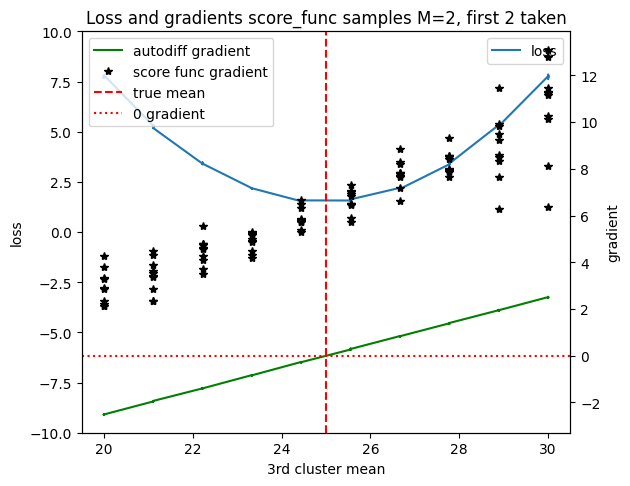

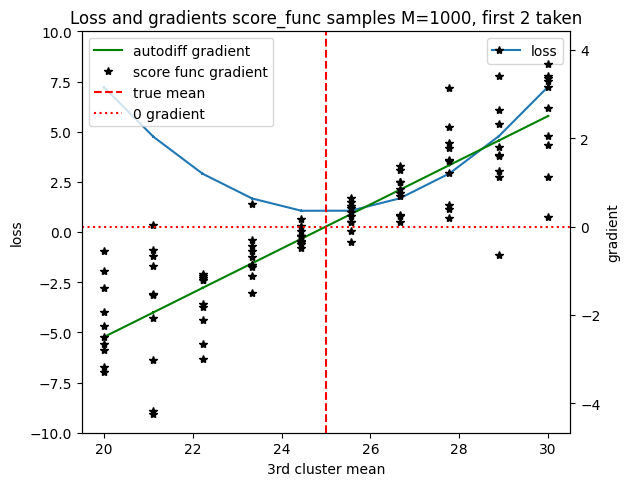

In [32]:
plot_big_results(big_analytical, autodiff_grads, losses, param_vals, T, M=2)
plot_big_results(big_analytical1k, autodiff_grads1k, losses1k, param_vals1k, T, M=1000, num_rows=2)

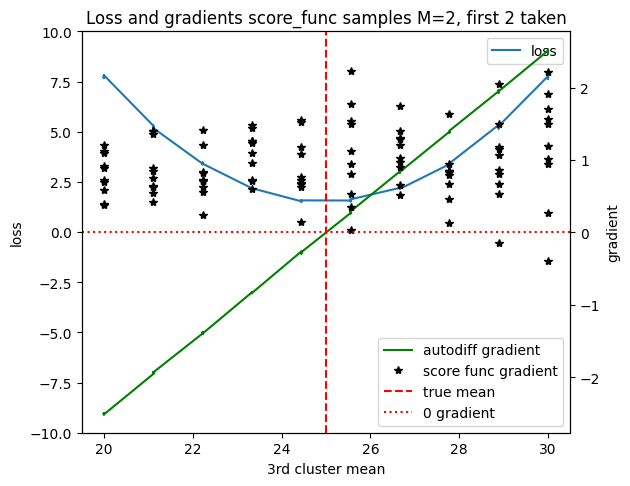

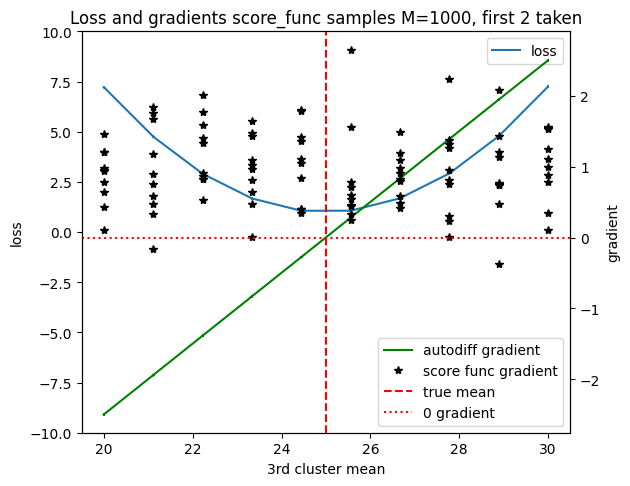

In [34]:
plot_big_results(big_grad_theta, autodiff_grads, losses, param_vals, T, M=2)
plot_big_results(big_grad_theta1k, autodiff_grads1k, losses1k, param_vals1k, T, M=1000, num_rows=2)

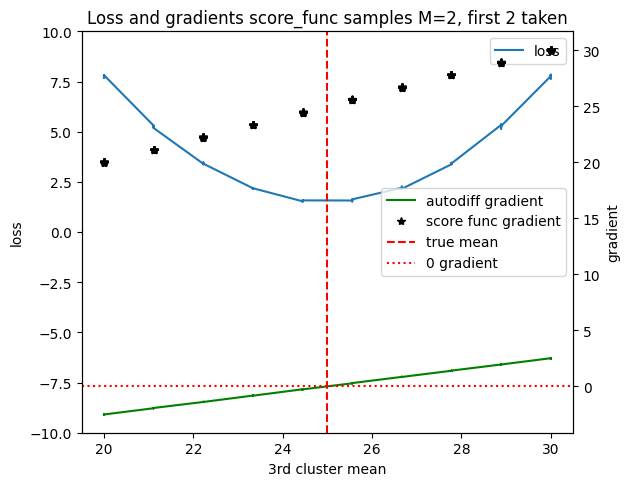

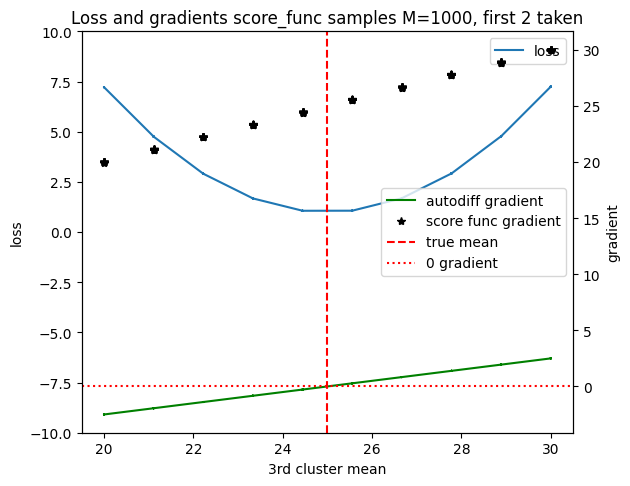

In [30]:
plot_big_results(big_sample, autodiff_grads, losses, param_vals, T, M=2)
plot_big_results(big_sample1k, autodiff_grads1k, losses1k, param_vals1k, T, M=1000, num_rows=2)

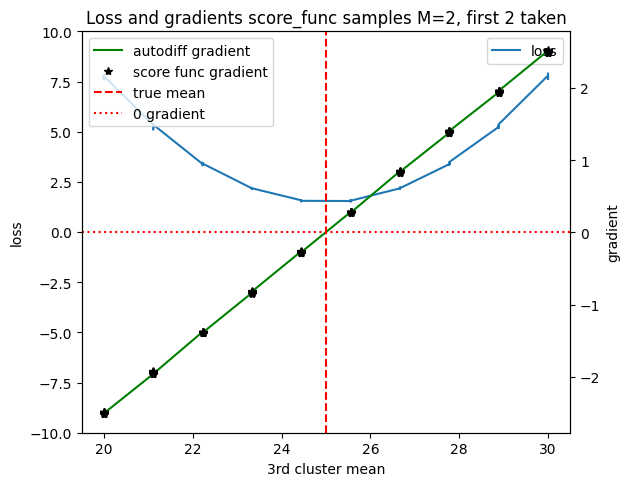

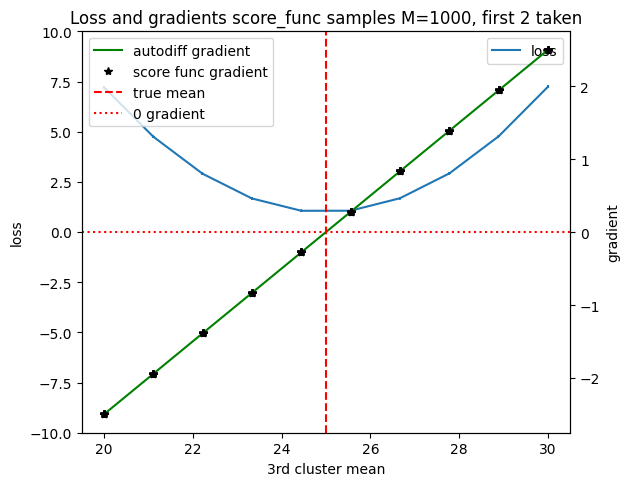

In [41]:
plot_big_results([tf.expand_dims(grad,axis=0) for grad in big_grad_L], autodiff_grads, losses, param_vals, T, M=2)
plot_big_results([tf.expand_dims(grad,axis=0) for grad in big_grad_L1k], autodiff_grads1k, losses1k, param_vals1k, T, M=1000, num_rows=2)

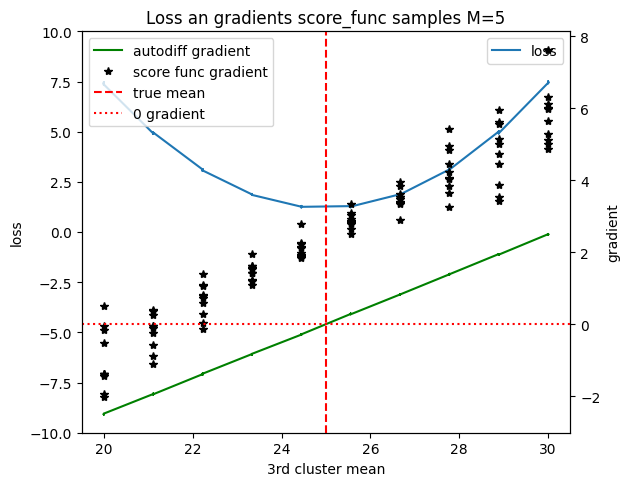

In [19]:
plot_results(analytical_grads, autodiff_grads, losses, param_vals, T)

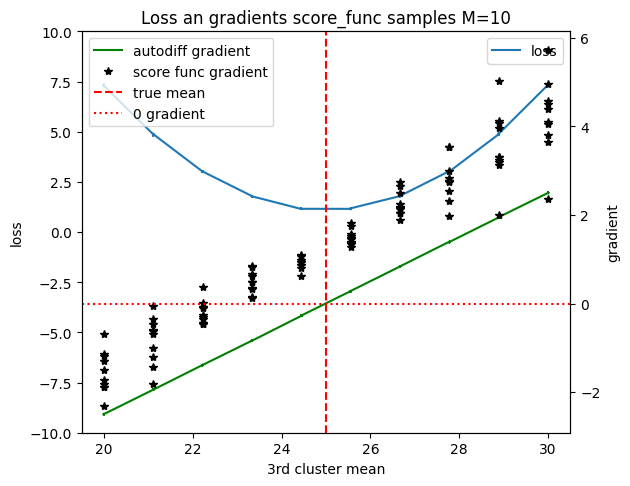

In [21]:
plot_results(analytical_grads, autodiff_grads, losses, param_vals, T)

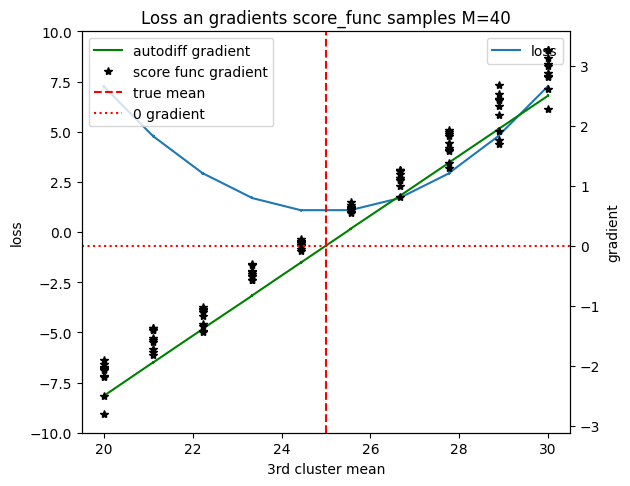

In [23]:
plot_results(analytical_grads, autodiff_grads, losses, param_vals, T)

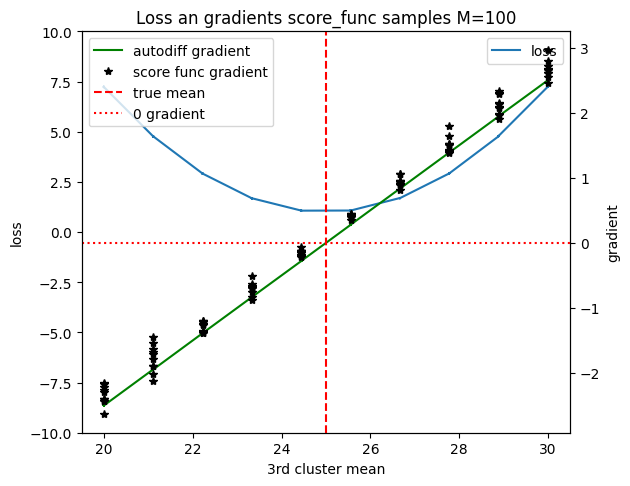

In [25]:
plot_results(analytical_grads, autodiff_grads, losses, param_vals, T)

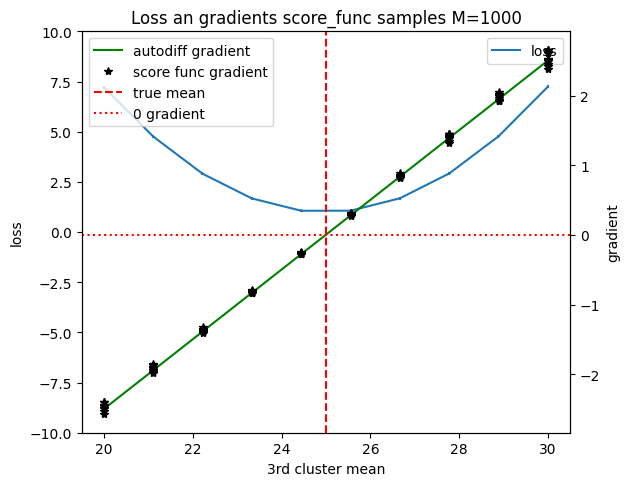

In [27]:
plot_results(analytical_grads, autodiff_grads, losses, param_vals, T)

In [38]:
big_grad_L1k

[<tf.Tensor: shape=(1000, 4), dtype=float32, numpy=
 array([[-3.4178305e-01,  6.6102219e-01, -3.2247839e+00, -6.8498421e-01],
        [ 2.3262501e-03, -4.6187639e-01, -2.5731153e+00, -9.5486450e-01],
        [ 5.3281713e-01, -3.6131954e-01, -2.4664030e+00,  5.0743294e-01],
        ...,
        [ 9.6556234e-01,  4.6960020e-01, -1.5892448e+00, -6.3400269e-01],
        [ 5.3300858e-01,  1.0649443e-01, -1.6037884e+00, -1.6833687e-01],
        [ 4.7259450e-01, -1.1738968e-01, -2.8533430e+00,  9.0529251e-01]],
       dtype=float32)>,
 <tf.Tensor: shape=(1000, 4), dtype=float32, numpy=
 array([[-0.36355472,  0.6908655 , -3.2149086 , -0.68530846],
        [-0.01960826, -0.45601463, -2.567007  , -0.9398289 ],
        [ 0.53943586, -0.35242558, -2.4811983 ,  0.5171013 ],
        ...,
        [ 0.94136953,  0.46767187, -1.6068449 , -0.62151146],
        [ 0.5592787 ,  0.12377357, -1.594801  , -0.18119049],
        [ 0.46558452, -0.09240484, -2.847309  ,  0.9346123 ]],
       dtype=float32)>,
 <tf

In [39]:
big_grad_L

[<tf.Tensor: shape=(1000, 4), dtype=float32, numpy=
 array([[-0.01810527,  0.7614708 , -3.2895489 , -0.6940384 ],
        [ 0.07103944, -0.7271342 , -3.0414095 , -0.53692627],
        [ 0.56689715, -0.38296127, -2.8993626 , -0.2459774 ],
        ...,
        [ 0.98092914, -0.03035927, -1.3195362 , -0.4237423 ],
        [ 0.62224627,  0.10570383, -1.6574287 ,  0.03804016],
        [ 0.17570901,  0.06067038, -3.3306656 ,  1.1283302 ]],
       dtype=float32)>,
 <tf.Tensor: shape=(1000, 4), dtype=float32, numpy=
 array([[-0.5529177 ,  0.2332201 , -3.2788658 ,  0.09749603],
        [ 0.4091208 , -0.22582102, -2.7059164 , -1.037775  ],
        [ 0.75246334, -0.50631857, -2.9532824 ,  1.1631641 ],
        ...,
        [ 0.47413468,  0.75148344, -1.288167  , -1.2940006 ],
        [ 0.15103436, -0.0798769 , -1.008934  ,  0.44172668],
        [ 0.39088178,  0.06765461, -2.8081665 ,  0.8669319 ]],
       dtype=float32)>,
 <tf.Tensor: shape=(1000, 4), dtype=float32, numpy=
 array([[-0.27166533,  0

In [42]:
mean_param = [5, 15, 25, 35]
variable = model.trainable_variables[1]
variable.assign(mean_param)

<tf.Variable 'UnreadVariable' shape=(4,) dtype=float32, numpy=array([ 5., 15., 25., 35.], dtype=float32)>

In [43]:
M=1000
with tf.GradientTape() as master_tape:
    model_distributions = model(x_TF)
    sample_y_MTS = model_distributions.sample(M)
    
    grad_theta_wrt_phi_MTS = (sample_y_MTS - model.trainable_variables[1])*sample_y_MTS
    grad_theta_wrt_phi_TS = tf.reduce_mean(grad_theta_wrt_phi_MTS, axis=0)

    sample_actions_MTS = tf.identity(sample_y_MTS)
    expected_actions_TS = tf.reduce_mean(sample_actions_MTS, axis=0)
    loss_T = keras.losses.mean_squared_error(y_TS, expected_actions_TS)
    loss = tf.reduce_mean(loss_T)
    grad_L_wrt_theta_TS = -2.0/S*(y_TS-expected_actions_TS)

analytical_gradient_MTS = grad_theta_wrt_phi_MTS*tf.expand_dims(grad_L_wrt_theta_TS,axis=0)
analytical_gradient_TS = grad_theta_wrt_phi_TS*grad_L_wrt_theta_TS
master_gradient = master_tape.gradient(loss_T, model.trainable_weights)

In [44]:
M=2
with tf.GradientTape() as master_tape:
    model_distributions2 = model(x_TF)
    sample_y_MTS2 = model_distributions2.sample(M)

    grad_theta_wrt_phi_MTS2 = (sample_y_MTS2 - model.trainable_variables[1])*sample_y_MTS2
    grad_theta_wrt_phi_TS2 = tf.reduce_mean(grad_theta_wrt_phi_MTS2, axis=0)

    sample_actions_MTS2 = tf.identity(sample_y_MTS2)
    expected_actions_TS2 = tf.reduce_mean(sample_actions_MTS2, axis=0)
    loss_T2 = keras.losses.mean_squared_error(y_TS, expected_actions_TS2)
    loss2 = tf.reduce_mean(loss_T2)
    grad_L_wrt_theta_TS2 = -2.0/S*(y_TS-expected_actions_TS2)

analytical_gradient_MTS2 = grad_theta_wrt_phi_MTS2*tf.expand_dims(grad_L_wrt_theta_TS2,axis=0)
analytical_gradient_TS2 = grad_theta_wrt_phi_TS2*grad_L_wrt_theta_TS2
master_gradient2 = master_tape.gradient(loss_T2, model.trainable_weights)

In [52]:
print(f'grad from 2 samples {tf.reduce_mean(tf.reduce_mean(analytical_gradient_MTS2,axis=0),axis=0)[2]}')
print(f'grad from 2 rows of 1k samples {tf.reduce_mean(tf.reduce_mean(analytical_gradient_MTS[:2,:,:],axis=0),axis=0)[2]}')
print(f'grad from 1k rows of 1k samples {tf.reduce_mean(tf.reduce_mean(analytical_gradient_MTS,axis=0),axis=0)[2]}')

grad from 2 samples 6.314281940460205
grad from 2 rows of 1k samples 0.0102029824629426
grad from 1k rows of 1k samples 0.02949577569961548


In [53]:
print(f'grad theta/phi from 2 samples {tf.reduce_mean(tf.reduce_mean(grad_theta_wrt_phi_MTS2,axis=0),axis=0)[2]}')
print(f'grad theta/phi from 2 rows of 1k samples {tf.reduce_mean(tf.reduce_mean(grad_theta_wrt_phi_MTS[:2,:,:],axis=0),axis=0)[2]}')
print(f'grad theta/phi from 1k rows of 1k samples {tf.reduce_mean(tf.reduce_mean(grad_theta_wrt_phi_MTS,axis=0),axis=0)[2]}')

grad theta/phi from 2 samples 0.42186611890792847
grad theta/phi from 2 rows of 1k samples 1.600027084350586
grad theta/phi from 1k rows of 1k samples 1.0059535503387451


In [56]:
print(f'grad L/theta from 2 samples {tf.reduce_mean(grad_L_wrt_theta_TS2,axis=0)[2]}')
print(f'grad L/theta from 2 rows of 1k samples {tf.reduce_mean(grad_L_wrt_theta_TS,axis=0)[2]}')
print(f'grad L/theta from 1k rows of 1k samples {tf.reduce_mean(grad_L_wrt_theta_TS,axis=0)[2]}')

grad L/theta from 2 samples -0.008541413582861423
grad L/theta from 2 rows of 1k samples 0.00270021241158247
grad L/theta from 1k rows of 1k samples 0.00270021241158247


In [57]:
grad_theta_wrt_phi_MTS2.shape

TensorShape([2, 1000, 4])

In [58]:
grad_L_wrt_theta_TS2.shape

TensorShape([1000, 4])

In [59]:
grad_theta_wrt_phi_MTS2*tf.expand_dims(grad_L_wrt_theta_TS2,axis=0)

<tf.Tensor: shape=(2, 1000, 4), dtype=float32, numpy=
array([[[-8.5034832e-02, -2.0749004e+01,  1.4232280e+01,  1.4422949e+01],
        [ 4.9089259e-01, -8.0535851e+00,  3.9475966e-02, -3.4206505e+01],
        [-3.5820022e-01, -3.5636599e+00,  4.1173820e+00,  8.1858492e+00],
        ...,
        [ 6.4110370e+00, -1.6931916e+00, -5.6458883e+00,  4.2896809e+01],
        [-1.0746770e+00,  1.3168198e+01, -8.0143871e+00,  1.0111303e+01],
        [ 3.6760643e+00,  1.6537432e-01, -1.9470482e+00, -1.8841888e+01]],

       [[-5.8551961e-01,  2.7642834e+01,  6.0879259e+00, -8.3437481e+00],
        [ 2.0125484e+00,  1.3751480e+01, -1.3935387e-01,  5.2697387e+00],
        [-7.4253649e-01,  1.3132782e+00,  1.2395109e+00,  4.5257645e+01],
        ...,
        [ 3.6507654e+00, -1.1275438e+00, -1.9168242e+00, -2.5092417e+01],
        [ 5.8552533e-01,  6.3500195e+00, -8.5602808e-01,  5.0777752e+01],
        [ 6.8555951e+00,  1.4032982e-01, -7.3612833e-01, -7.9094186e+00]]],
      dtype=float32)>